# Common Corpus - Jina & Anisa
This aim of this project was to produce a visualization of a conversation between Jina and Anisa about an upcoming exhibition "Utsu". The exhibition included photography, painting, mixed media, and music exploring the topic of depression.

The exhibition was created by Jina who designed, directed, and modelled in photographs by multiple photographers. Anisa was one of the main contributors and collaborators, with both her own original paintings and creating mixed media art from Jina's photographs.

Jina's primary aim was to share her experiences with depression with her friends and to raise awareness of the reality of depression, especially among Japanese attendees.

## Conversation Analysis
During the original 3 hours of conversation, I asked a few prompt questions, meaning there are three voices to be distinguished in the audio files.

Unfortunately I couldn't find a voice-to-text algorithm both up for the task and learnable with my time/money resources, so I transcribed the majority of the conversation between Jina and Anisa manually. This also gave me the opportunity to break up and label the conversation into topics, while getting a stronger feel for their individual speaking styles/verbal tics and filtering out irrelevant side-conversations (such as the Go Home music playing at 5PM).

This gave me a list of three main topics split between two speakers and a sense of the full story that was to be communicated.

I decided that the final visualisation would be two radar diagrams - one for each speaker. The radar diagram would be triangular, one spoke for each topic. The series on the diagram would be the most frequently used words used in the conversation or by only that speaker. The data of each series would be that speaker's share of that word for the topic to show the similarities and differences between Jina and Anisa.

For example, we would expect the word "depression" to be almost equally shared between Jina and Anisa across the different topics as it is the common theme. However when talking about their art, we would expect their different methods of expression to belong more strongly to either Jina (photography) or Anisa (painting).

In [583]:
import nltk
import numpy
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer

def cleanString(_sentence):
    _sentence = _sentence.lower().replace("kind of","")
    _sentence = _sentence.replace("'ll","").replace("'ve","").replace("'re","").replace("'m","").replace("n't","").replace("'s","")
    _sentence = _sentence.replace("-"," ").replace("'"," ").replace(".","").replace(",","").replace('"',"").replace('?',"")
    return _sentence

def verbatimConcat(_sentences):
    _concat_sentences = cleanString(_sentences[0])
    for _sent in _sentences[1:]:
        _concat_sentences = _concat_sentences + " " + cleanString(_sent)
    return _concat_sentences

def verbatimClean(_verbatim):
    pst = PorterStemmer()
    _tokens = [pst.stem(_t) for _t in verbatimConcat(_verbatim).split() if len(pst.stem(_t)) > 1 and _t not in stop_words]
    return _tokens
    
def verbatimFreq(_tokens):
    _verbatim_freq = nltk.FreqDist(verbatimClean(_tokens))
    return _verbatim_freq

stop_words = ["the","an","and","like",
              "i","you","we","they","he","she","him","her","us","me","your","my","his","hers","them","one",
              "not","am","this","that","those","was","with","oh","ah","or","there","been","be","being","from","were",
              "are","is","it","would","could","to","have","can","do","did","does","ca","on","for","if",
              "of","but","so","in","at","just","really","even","too","because","also","out","however","lot",
              "most","least","much","more","little","some","thing","as","actually","maybe","about","had","yeah",
              "through","although","though",
              "when","who","what","where","why","how","then","no","yes","maybe","well",
              "go","get","want","going","say","saying","great","okay","want",
              "jina","anisa"]

In [584]:
conversations = pd.read_csv("transcript.tsv",sep='\t')

# Merging similar topics to simplify visualisation
conversations.Topic = conversations.Topic.apply(lambda x: "Exhibition" if "Exhibition" in x else x)
conversations.Topic = conversations.Topic.apply(lambda x: "Exhibition" if "Other" in x else x)
conversations.Topic = conversations.Topic.apply(lambda x: "Experiences" if "Victories" in x else x)

topics = list(set(conversations.Topic))

jina = conversations[conversations["Speaker"]=="Jina"]
anisa = conversations[conversations["Speaker"]=="Anisa"]
conv = jina.append(anisa)

In [585]:
jina_dict = {}
anisa_dict = {}
conv_dict = {}

for topic in topics:
    jina_dict[topic] = verbatimFreq(jina[jina.Topic==topic]["Verbatim"].to_list())
    anisa_dict[topic] = verbatimFreq(anisa[anisa.Topic==topic]["Verbatim"].to_list())
    conv_dict[topic] = verbatimFreq(conv[conv.Topic==topic]["Verbatim"].to_list())

Exhibition


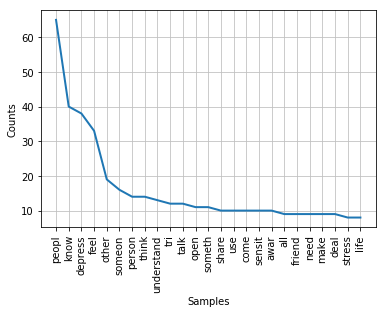

Art


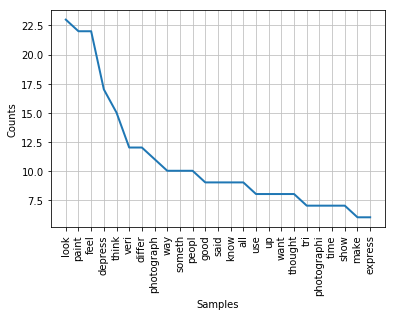

Experiences


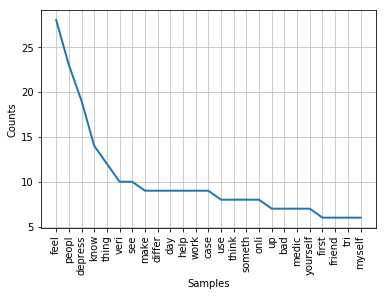

In [586]:
for topic in topics:
    print(topic)
    conv_dict[topic].plot(25)

## Balancing the Bias
Technically we could use the word frequency distributions at this point. However, I want to make sure that Jina and Anisa have equal input in the model. So what I'm going to do is intra-scale the frequency distributions.

### Wait, Intra-Scale?
Intra-scale is the name I gave to a two-step scaling method I developed and used in my research. I wanted to analyse a platform process used by a cell-line to express different products. The challenge was that the different products affected the cells differently so it was difficult to separate the impact of the process and product on the cell's performance. This is called confounding, and confound it all, it can be a major issue!

In [588]:
# Convert to dictionaries and cross-scale.